Data Analysis

In [1]:
import pandas as pd

# Store data in a Dataframe
train = pd.read_csv("./raw_data/train.csv")
test = pd.read_csv("./raw_data/test.csv")
submission = pd.read_csv("./raw_data/sample_submission.csv")

In [2]:
def add_features(df, is_train=False):
    # Safe operations (present in both train and test)
    df["Speed_vs_Grid"] = df["Avg_Speed_kmh"] / (df["Grid_Position"] + 1)
    df["Ambient_vs_Track_Temp"] = df["Ambient_Temperature_Celsius"] / (df["Track_Temperature_Celsius"] + 1)
    df["Humidity_Normalized"] = df["Humidity_%"] / 100
    df["Finish_Rate"] = df["finishes"] / (df["starts"] + 1)
    df["Podium_Rate"] = df["podiums"] / (df["starts"] + 1)
    df["Win_Rate"] = df["wins"] / (df["starts"] + 1)
    df["Points_Per_Year"] = df["Championship_Points"] / (df["years_active"] + 1)

    if is_train:
        # Only apply to training data (where Lap_Time_Seconds is available)
        df["Lap_Duration_per_km"] = df["Lap_Time_Seconds"] / (df["Circuit_Length_km"] + 1e-6)
        df["Speed_vs_Avg"] = df["Avg_Speed_kmh"] / (df["Lap_Time_Seconds"] + 1e-6)
        df["Grid_vs_Position"] = df["Grid_Position"] - df["position"]
        df["Position_Rank"] = df["Championship_Position"] / (df["Championship_Points"] + 1)

    return df

train = add_features(train, is_train=True)
test = add_features(test, is_train=False)


In [3]:
# Train Data
X = train.drop(columns=["Lap_Time_Seconds"])
y = train["Lap_Time_Seconds"]

# Test data
X_test = test.copy()

# One Hot Encode Categorical data
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

# Align test data with train data based on columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

In [4]:
# Generalize column names for lgb
original_cols = X.columns.tolist()

X.columns = [f"f{i}" for i in range(X.shape[1])]
X_test.columns = X.columns 

Model Training

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14069
[LightGBM] [Info] Number of data points in the train set: 1531244, number of used features: 3989
[LightGBM] [Info] Start training from score 90.001982
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.452573	valid_0's l2: 0.204822
[200]	valid_0's rmse: 0.306146	valid_0's l2: 0.0937253
[300]	valid_0's rmse: 0.268038	valid_0's l2: 0.0718444
[400]	valid_0's rmse: 0.246807	valid_0's l2: 0.0609135
[500]	valid_0's rmse: 0.22954	valid_0's l2: 0.0526888
[600]	valid_0's rmse: 0.218313	valid_0's l2: 0.0476605
[700]	valid_0's rmse: 0.208185	valid_0's l2: 0.0433411
[800]	valid_0's rmse: 0.200603	valid_0's l2: 0.0402415
[900]	valid_0's rmse: 0.194005	valid_0's l2: 0.037638
[1000]	valid_0's rmse: 0.189225	val

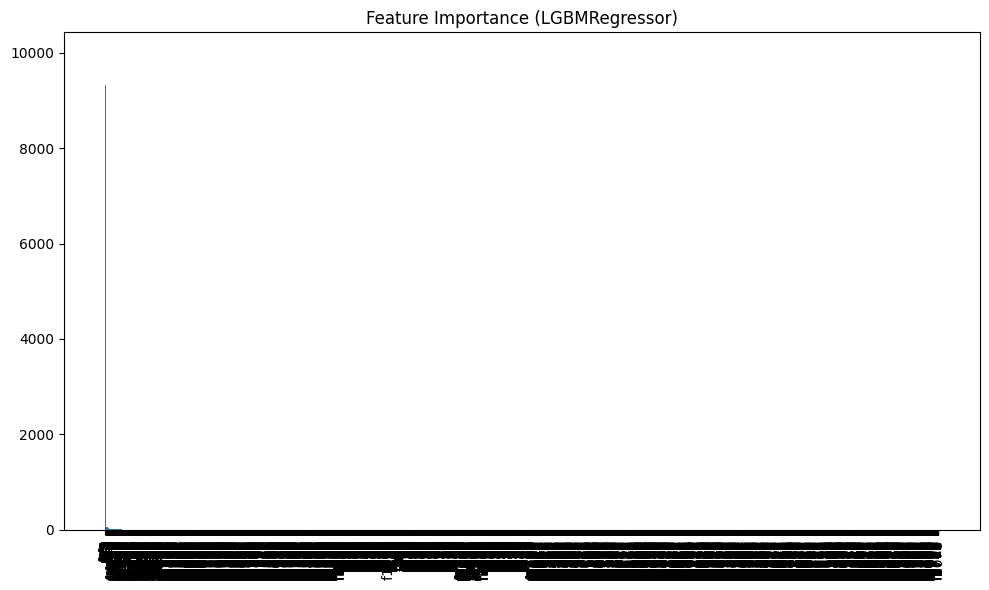

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split

# 1. Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train model
model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# 3. Feature importance plot
importances = model.feature_importances_
features = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (LGBMRegressor)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

In [6]:
# Submission
preds = model.predict(X_test)
submission["Lap_Time_Seconds"] = preds
submission.to_csv("submission.csv", index=False)